In [2]:
# Standard libraries
import math                                                 # Mathematical functions (sin, cos, sqrt, etc.)
import random                                               # Random number generation and sampling
import sys                                                  # System-specific parameters and functions (e.g. exit, argv)
import os                                                   # Operating system interfaces (file paths, environment variables)

# Scientific computing and data handling
import numpy as np                                          # Numerical computing (arrays, linear algebra, etc.)
import matplotlib.pyplot as plt                             # Plotting and visualization
import csv                                                  # Reading and writing CSV files
import pandas as pd                                         # Data manipulation and analysis (DataFrames, Series)

# Python type hints and data structures
from dataclasses import dataclass                           # Decorator for creating classes with auto-generated special methods
from typing import Tuple                                    # Type hints for tuples and other complex types

# PyTorch: Deep learning framework
import torch                                                # Tensors and neural network building blocks
from torch import nn                                        # Neural network layers and loss functions
from torch.utils.data import Dataset, DataLoader            # Dataset and batch loading utilities

# PyTorch Lightning: High-level interface for PyTorch
import lightning as L                                       # Core Lightning module
from lightning.pytorch import Trainer                       # Training loop management
from lightning.pytorch.callbacks import (                   # Training utilities:
    EarlyStopping,                                          # Stop training when a metric stops improving
    ModelCheckpoint,                                        # Save the best model during training
    TQDMProgressBar                                         # Progress bar for training
)
from lightning.pytorch.loggers import TensorBoardLogger     # Logging to TensorBoard

# Metrics for model evaluation
import torchmetrics as tm                                   # Collection of metrics (RMSE, Accuracy, etc.) for PyTorch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\dilla\anaconda3\envs\torch-gpu\Lib\site-packages\lightning\fabric\__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


Le fichier CSV a 2999 lignes et 2000 colonnes.


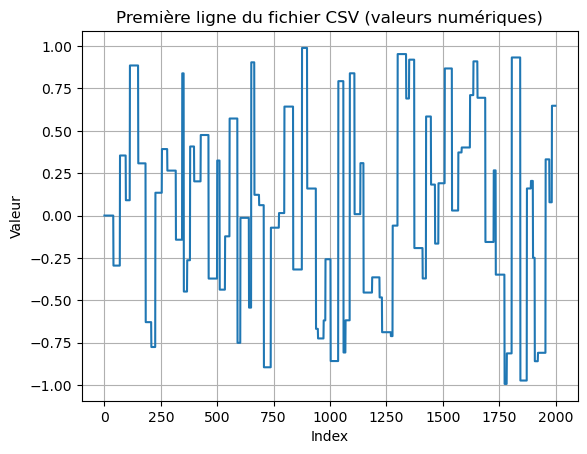

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le fichier CSV
file_path = 'Student_folder/Student_folder/bdd_in_mat_05.csv'
# Lire en texte au départ pour éviter que pandas n'infère des entiers monstrueux
data = pd.read_csv(file_path, dtype=str)

# Afficher les dimensions (lignes, colonnes)
print(f"Le fichier CSV a {data.shape[0]} lignes et {data.shape[1]} colonnes.")

# Récupérer la première ligne et convertir en numérique de façon sûre
first_row = data.iloc[0].copy()
first_row = pd.to_numeric(first_row, errors='coerce')

# Forcer en float64 pour éviter des conversions vers des C longs dans les extensions
first_row = first_row.astype('float64')

# Remplacer infinis par NaN (sécurité supplémentaire)
first_row.replace([float('inf'), float('-inf')], pd.NA, inplace=True)

# Supprimer les NaN (valeurs non numériques)
first_row = first_row.dropna()

# Tracer
plt.plot(first_row.values)
plt.title("Première ligne du fichier CSV (valeurs numériques)")
plt.xlabel("Index")
plt.ylabel("Valeur")
plt.grid(True)
plt.show()


Le fichier CSV a 2999 lignes et 2000 colonnes.


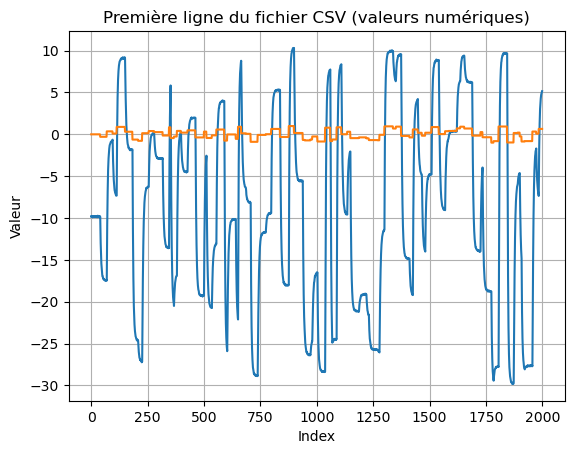

In [4]:

# Charger le fichier CSV
file_path2 = 'Student_folder/Student_folder/bdd_out_mat_05.csv'
# Lire en texte au départ pour éviter que pandas n'infère des entiers monstrueux
data2 = pd.read_csv(file_path2, dtype=str)

# Afficher les dimensions (lignes, colonnes)
print(f"Le fichier CSV a {data2.shape[0]} lignes et {data2.shape[1]} colonnes.")

# Récupérer la première ligne et convertir en numérique de façon sûre
first_row_out = data2.iloc[0].copy()
first_row_out = pd.to_numeric(first_row_out, errors='coerce')

# Forcer en float64 pour éviter des conversions vers des C longs dans les extensions
first_row_out = first_row_out.astype('float64')

# Remplacer infinis par NaN (sécurité supplémentaire)
first_row_out.replace([float('inf'), float('-inf')], pd.NA, inplace=True)

# Supprimer les NaN (valeurs non numériques)
first_row_out = first_row_out.dropna()

# Tracer

plt.plot(first_row_out.values)
plt.plot(first_row.values)
plt.title("Première ligne du fichier CSV (valeurs numériques)")
plt.xlabel("Index")
plt.ylabel("Valeur")
plt.grid(True)
plt.show()


Aucune valeur infinie dans les données d'entrée.
Aucune valeur infinie dans les données de sortie.
2000 2000


In [6]:
def load_csv_to_tensors(input_csv: str, target_csv: str, input_size: int = 1, output_size: int = 1, has_header: bool = False):
    """
    Load two CSV files (inputs U and outputs Y) and convert them into PyTorch tensors.
    
    Assumptions:
      - Each row in the CSV represents a full sequence (trajectory)
      - Columns represent time steps in a 'wide' format
      - input_size and output_size define the number of features per time step
    
    Args:
        input_csv (str): Path to the CSV file containing input sequences (U)
        target_csv (str): Path to the CSV file containing output sequences (Y)
        input_size (int): Number of input features per time step
        output_size (int): Number of output features per time step
        has_header (bool): True if the CSV files include a header row
    
    Returns:
        X (torch.Tensor): Input tensor of shape (N, T, input_size)
        Y (torch.Tensor): Output tensor of shape (N, T, output_size)
    """
    
    # Determine header option for pandas
    header = 0 if has_header else None
    
    # Load CSV files into NumPy arrays (float32 for PyTorch compatibility)
    U = pd.read_csv(input_csv, header=header).values.astype('float32')
    Y = pd.read_csv(target_csv, header=header).values.astype('float32')
    
    # Check that both files have the same number of sequences
    if U.shape[0] != Y.shape[0]:
        raise ValueError(f"Number of sequences differs: U has {U.shape[0]}, Y has {Y.shape[0]}.")
    
    # Helper function to reshape from (N, T*dim) to (N, T, dim)
    def reshape(arr, dim):
        if arr.shape[1] % dim != 0:
            raise ValueError(f"Number of columns {arr.shape[1]} is not divisible by dim={dim}.")
        T = arr.shape[1] // dim
        return arr.reshape(arr.shape[0], T, dim)
    
    # Reshape both input and output arrays
    U = reshape(U, input_size)
    Y = reshape(Y, output_size)
    
    # Convert to PyTorch tensors
    X = torch.tensor(U, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)
    
    return X, Y


In [7]:
class dataModule(L.LightningDataModule):
    """
    LightningDataModule for handling dataset splitting and loading.
    This class prepares the data for training, validation, and testing in PyTorch Lightning.
    """
    def __init__(self, data_u, data_y, batch_size=32):
        """
        Initialize the data module with input and output data.

        Args:
            data_u (torch.Tensor): Input data tensor.
            data_y (torch.Tensor): Output data tensor.
            batch_size (int, optional): Number of samples per batch. Defaults to 32.
        """
        super().__init__()
        self.batch_size = batch_size
        self.N = data_u.shape[0]  # Total number of samples
        self.data_u = data_u  # Store input data
        self.data_y = data_y  # Store output data

    def setup(self, stage=None):
        """
        Split the dataset into training, validation, and test sets.

        Args:
            stage (str, optional): Stage of the training process (fit, validate, test, predict). Defaults to None.
        """
        self.N_train = int(0.7*self.N)  # 70% of data for training                         % To be completed
        self.N_val =   int(0.15*self.N)# 15% of data for validation                         % To be completed
        self.N_test =  self.N - self.N_train - self.N_val# Remaining 15% for testing                         % To be completed

        # Create TensorDatasets for each split
        # Train set
        self.train_dataset = torch.utils.data.TensorDataset(
            self.data_u[:self.N_train, :], self.data_y[:self.N_train, :]
        )

        # Vaidation set
        self.val_dataset = torch.utils.data.TensorDataset(
            self.data_u[self.N_train:self.N_train+self.N_val, :], self.data_y[self.N_train:self.N_train+self.N_val, :]  
        )
        
        # Test set
        self.test_dataset = torch.utils.data.TensorDataset(
            self.data_u[self.N_train+self.N_val:, :], self.data_y[self.N_train+self.N_val:, :]
        )

    def train_dataloader(self):
        """
        Return the DataLoader for the training set.

        Returns:
            DataLoader: Training data loader with shuffling.
        """
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        """
        Return the DataLoader for the validation set.

        Returns:
            DataLoader: Validation data loader without shuffling.
        """
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        """
        Return the DataLoader for the test set.

        Returns:
            DataLoader: Test data loader without shuffling.
        """
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

In [8]:
# Define the dimensions of input and output for the model
csv_u = 'Student_folder/Student_folder/bdd_in_mat_05.csv'  # Path to the input CSV file
csv_y = 'Student_folder/Student_folder/bdd_out_mat_05.csv'        # Path to the output CSV file


input_size = 1                              # Number of input features per time step         # To be completed
output_size = 1                             # Number of output features per time step        # To be completed
has_header = True                          # Flag indicating whether the CSV files have a header row

# Load the input and output data from CSV files into PyTorch tensors
tensor_u, tensor_y = load_csv_to_tensors(
    csv_u,                                  # Path to the input CSV file
    csv_y,                                  # Path to the output CSV file
    input_size,                             # Number of input features
    output_size,                            # Number of output features
    has_header                              # Whether the CSV files have a header row
)

print(tensor_u.shape, tensor_y.shape)

torch.Size([2999, 2000, 1]) torch.Size([2999, 2000, 1])


In [15]:
class model_nn(L.LightningModule):
    """
    Sequential neural network model (RNN/LSTM/GRU) for aligned sequence-to-sequence mapping U->Y.
    """
    def __init__(
        self,
        input_size: int = 1 ,        # 1 input feature per time step
        output_size: int = 1 ,       # 1 output feature per time step
        rnn_type: str = "RNN",  # "RNN", "LSTM", "GRU" - LSTM is better for sequences
        hidden_size: int = 16 ,       # Increased for better capacity
        num_layers: int = 1 ,        # More layers for better learning
        dropout: float = 0.1,        # Add some dropout for regularization
        lr: float = 1e-3,
        weight_decay: float = 1e-4,  # Add weight decay for regularization
        bidirectional: bool = False,
    ):
        """
        Initialize the model with the specified architecture and hyperparameters.

        Args:
            input_size (int): Number of input features.
            output_size (int): Number of output features.
            rnn_type (str): Type of recurrent layer ("RNN", "LSTM", "GRU").
            hidden_size (int): Number of hidden units in the RNN layer.
            num_layers (int): Number of recurrent layers.
            dropout (float): Dropout probability between RNN layers.
            lr (float): Learning rate for the optimizer.
            weight_decay (float): Weight decay (L2 penalty) for the optimizer.
            bidirectional (bool): If True, becomes a bidirectional RNN.
        """
        super().__init__()
        self.save_hyperparameters()
        # Select and initialize the RNN type
        if rnn_type.upper() == "LSTM":
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0.0,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif rnn_type.upper() == "GRU":
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout=dropout if num_layers > 1 else 0.0,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif rnn_type.upper() == "RNN":
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                nonlinearity='tanh',
                dropout=dropout if num_layers > 1 else 0.0,
                bidirectional=bidirectional,
                batch_first=True
            )
        else:
            raise ValueError("rnn_type must be one of {'RNN','LSTM','GRU'}")
        # Linear head for output projection
        d = 2 if bidirectional else 1
        self.head = nn.Linear(d * hidden_size, output_size)
        self.loss_fn = nn.MSELoss()  # Mean squared error loss

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch, T, input_size).
    
        Returns:
            torch.Tensor: Output tensor of shape (batch, T, output_size).
        """
        h, _ = self.rnn(x)              # h: (batch, T, d*hidden_size)
        y = self.head(h)                # y: (batch, T, output_size)
        return y

    def training_step(self, batch, batch_idx):
        """
        Training step: forward pass, loss computation, and logging.

        Args:
            batch: Tuple of (input, target) tensors.
            batch_idx: Index of the current batch.

        Returns:
            torch.Tensor: Computed loss.
        """
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step: forward pass, loss computation, and logging.

        Args:
            batch: Tuple of (input, target) tensors.
            batch_idx: Index of the current batch.
        """
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        """
        Test step: forward pass, loss computation, and logging.

        Args:
            batch: Tuple of (input, target) tensors.
            batch_idx: Index of the current batch.
        """
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        """
        Configure the optimizer for training.

        Returns:
            torch.optim.Optimizer: Adam optimizer instance.
        """
        opt = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )
        return opt


In [16]:
def train_run(data_u, data_y, model_save_name, epoch_max=10, nb_train=1, patience_EarlyStopping=200, refresh_rate_brogress_bar=10, batch_size = 32):
    """
    Train a model multiple times with the given data and save the results.

    Args:
        data_u (np.ndarray): Input data for training.
        data_y (np.ndarray): Output data for training.
        model_save_name (str): Name of the directory to save model logs and checkpoints.
        epoch_max (int, optional): Maximum number of training epochs. Defaults to 10.
        nb_train (int, optional): Number of training runs. Defaults to 1.
        patience_EarlyStopping (int, optional): Patience for early stopping. Defaults to 200.
        refresh_rate_brogress_bar (int, optional): Refresh rate for the progress bar. Defaults to 10.
    """
    for index_train in range(nb_train):
        print("Train ", index_train)
        # Initialize the data module with input and output data
        data_module = dataModule(data_u, data_y, batch_size=batch_size)

        # Initialize the model with LSTM (not RNN) for better performance
        model = model_nn(
            rnn_type="RNN",      # Use LSTM instead of RNN
            hidden_size=16,       # Increase from 32 to 64
            num_layers=1,         
            dropout=0.1,          # Add dropout for regularization
            lr=1e-3,
            weight_decay=1e-4
        )

        # Set up TensorBoard logger to save training logs
        logger = L.pytorch.loggers.TensorBoardLogger(model_save_name)

        # Early stopping callback to halt training if validation loss does not improve
        early_stopping_callback = EarlyStopping(
            monitor='val_loss',
            patience=patience_EarlyStopping,
            mode='min'
        )

        # Model checkpoint callback to save the best model based on validation loss
        checkpoint_callback = ModelCheckpoint(
            monitor='val_loss',  # Metric to monitor for saving the best model
            dirpath=logger.log_dir,  # Directory to save the model checkpoints
            filename='model-{epoch:02d}-{val_loss:.2f}',  # Filename format for saved models
            save_top_k=1,  # Save only the best model
            mode='min',  # Save the model with the minimum validation loss
        )

        # Initialize the trainer with callbacks and logger
        trainer = L.Trainer(
            max_epochs=epoch_max,
            logger=logger,
            callbacks=[
                early_stopping_callback,
                checkpoint_callback,
                TQDMProgressBar(refresh_rate=refresh_rate_brogress_bar)
            ],
            accelerator='gpu',  # Automatically use available GPUs
            devices=1,
        )

        # Train the model
        trainer.fit(model, data_module)

        # Test the model after training
        trainer.test(model, datamodule=data_module)

        # Print the logger information
        print(logger)


In [17]:
# Define the name for saving the model and logs
model_save_name = 'model_rnn'               # Directory name where model checkpoints and logs will be saved

# Run the training process with the specified parameters
train_run(
    tensor_u,                               # Input data tensor
    tensor_y,                               # Output data tensor
    model_save_name,                        # Name for saving the model
    epoch_max=100,                         # Maximum number of training epochs
    nb_train=1,                             # Number of training runs
    patience_EarlyStopping=20,             # Number of epochs to wait before early stopping if no improvement
    refresh_rate_brogress_bar=10,           # Refresh rate for the progress bar (in batches)
    batch_size = 32
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\dilla\anaconda3\envs\torch-gpu\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory model_rnn\lightning_logs\version_3 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | rnn     | RNN     | 304   
1 | head    | Linear  | 17    
2 | loss_fn | MSELoss | 0     
------------------------------------
321       Trainable params
0         Non-trainable params
321       Total params
0.001     Total estimated model params size (MB)
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\dilla\anaconda3\envs\torch-gpu\Lib\site-packages\lightning\pytorch\callba

Train  0
Epoch 99: 100%|██████████| 66/66 [00:00<00:00, 148.22it/s, v_num=3, train_loss_step=387.0, val_loss=1.700, train_loss_epoch=16.90]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 66/66 [00:00<00:00, 148.22it/s, v_num=3, train_loss_step=387.0, val_loss=1.700, train_loss_epoch=16.90]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|██████████| 15/15 [00:00<00:00, 464.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.7051349878311157     │
└───────────────────────────┴───────────────────────────┘

In [82]:
import torch
print(torch.cuda.is_available())

import torch, os
print("torch.__version__:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)  # None => build CPU-only
print("cuda.is_available():", torch.cuda.is_available())
print("num GPUs seen by torch:", torch.cuda.device_count())
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    print("cuDNN:", torch.backends.cudnn.version()) 

True
torch.__version__: 2.5.1
torch.version.cuda: 12.4
cuda.is_available(): True
num GPUs seen by torch: 1
CUDA_VISIBLE_DEVICES: None
GPU name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
cuDNN: 90100


model_nn(
  (rnn): RNN(1, 16, batch_first=True)
  (head): Linear(in_features=16, out_features=1, bias=True)
  (loss_fn): MSELoss()
)
rnn.weight_ih_l0 torch.Size([16, 1])
rnn.weight_hh_l0 torch.Size([16, 16])
rnn.bias_ih_l0 torch.Size([16])
rnn.bias_hh_l0 torch.Size([16])
head.weight torch.Size([1, 16])
head.bias torch.Size([1])


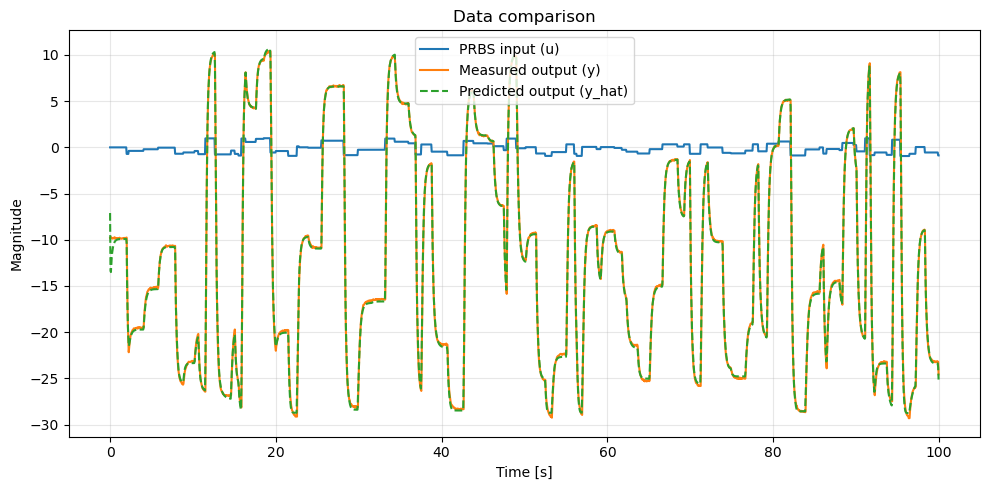

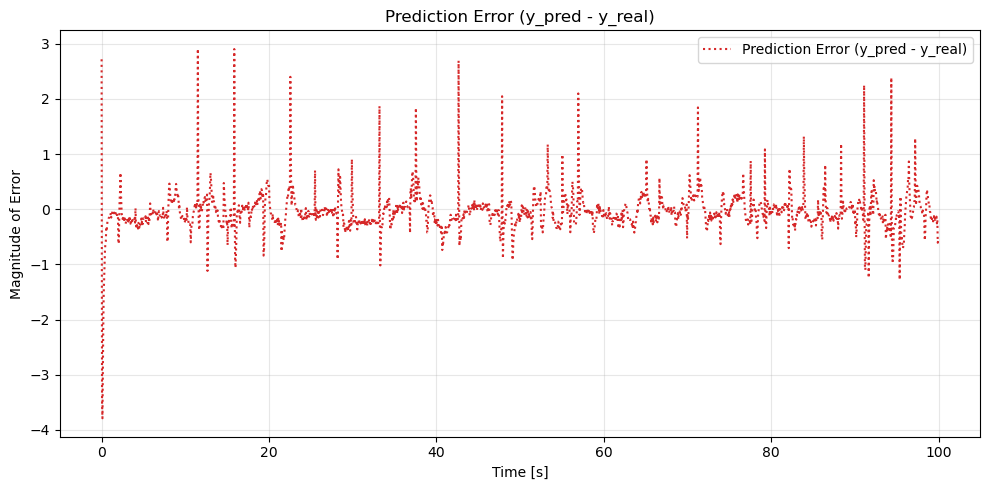

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Sampling time
Te = 0.05

model_path = 'model_rnn/lightning_logs/version_3/model-epoch=96-val_loss=0.14.ckpt'  # Path to the trained model checkpoint
model = model_nn.load_from_checkpoint(model_path)  # Load the model from checkpoint
model.to(device)  # Move the model to the appropriate device (CPU/GPU)
model.eval()  # Set the model to evaluation mode
print(model)  # Print model architecture and parameters

# Display detailed information about model parameters
for name, param in model.named_parameters():
    print(name, param.shape)  # Print parameter names and shapes

# Select a test sequence (here, the last one)
u_test = tensor_u[-1]  # Last input sequence from the dataset
y_test = tensor_y[-1]  # Corresponding output sequence

# Define the range for the time window (500 time steps between 1400 and 1900)
start_index = 0
end_index = 2900


u_test_section = u_test[start_index:end_index]  
y_test_section = y_test[start_index:end_index]  

# Add batch dimension and move to device if needed
u_test_in = u_test_section.unsqueeze(0).to(device)  # Reshape to (1, T, 1) and move to device

# Model prediction (no gradient computation)
with torch.no_grad():
    y_pred = model(u_test_in).squeeze(0).squeeze(-1).cpu().numpy()  # Get predictions and convert to numpy

# Prepare signals for plotting
u_plot = u_test_section.squeeze().numpy()  # Input signal (u) for plotting
y_real = y_test_section.squeeze().numpy()  # Measured output (y) for plotting
t = np.arange(len(u_plot)) * Te  # Time array for x-axis (adjust Te if needed)

# Plot the input, real output, and predicted output
plt.figure(figsize=(10, 5))
plt.plot(t, u_plot, label="PRBS input (u)", color='tab:blue')  # Plot input signal
plt.plot(t, y_real, label="Measured output (y)", color='tab:orange')  # Plot real output
plt.plot(t, y_pred, label="Predicted output (y_hat)", color='tab:green', linestyle='--')  # Plot predicted output
plt.xlabel("Time [s]")  # X-axis label
plt.ylabel("Magnitude")  # Y-axis label
plt.title("Data comparison")  # Plot title
plt.legend()  # Show legend
plt.grid(True, alpha=0.3)  # Add grid with transparency
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()




# Calculate the error (difference between prediction and real output)
error = y_pred - y_test_section.squeeze().numpy()

# Plot the error (difference between prediction and real output)
plt.figure(figsize=(10, 5))
plt.plot(t, error, label="Prediction Error (y_pred - y_real)", color='tab:red', linestyle=':')
plt.xlabel("Time [s]")  # X-axis label
plt.ylabel("Magnitude of Error")  # Y-axis label
plt.title("Prediction Error (y_pred - y_real)")  # Plot title
plt.legend()  # Show legend
plt.grid(True, alpha=0.3)  # Add grid with transparency
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()
